# IE6600 Project 2

Group2:


- 1) Venkata Sai Teja
- 2) Nandury Kousik
- 3) Vashani Neil



In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## 1) Data import and Inspection

In [4]:
df = pd.read_csv('VSRR_Provisional_Drug_Overdose_Death_Counts.csv')

In [5]:
print(f"Dataset shape: {df.shape}")
print(f"Time period: {df['Year'].min()} - {df['Year'].max()}")
print(f"Geographic coverage: {df['State'].nunique()} states/territories")
print(f"Drug indicators: {df['Indicator'].nunique()} different types")


Dataset shape: (76230, 12)
Time period: 2015 - 2025
Geographic coverage: 54 states/territories
Drug indicators: 12 different types


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76230 entries, 0 to 76229
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State                          76230 non-null  object 
 1   Year                           76230 non-null  int64  
 2   Month                          76230 non-null  object 
 3   Period                         76230 non-null  object 
 4   Indicator                      76230 non-null  object 
 5   Data Value                     62113 non-null  float64
 6   Percent Complete               76230 non-null  int64  
 7   Percent Pending Investigation  76230 non-null  float64
 8   State Name                     76230 non-null  object 
 9   Footnote                       76230 non-null  object 
 10  Footnote Symbol                76230 non-null  object 
 11  Predicted Value                49239 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usag

In [7]:
print(df.head())

  State  Year     Month           Period        Indicator  Data Value  \
0    AK  2015   January  12 month-ending  Cocaine (T40.5)         NaN   
1    AK  2015  February  12 month-ending  Cocaine (T40.5)         NaN   
2    AK  2015     March  12 month-ending  Cocaine (T40.5)         NaN   
3    AK  2015     April  12 month-ending  Cocaine (T40.5)         NaN   
4    AK  2015       May  12 month-ending  Cocaine (T40.5)         NaN   

   Percent Complete  Percent Pending Investigation State Name  \
0               100                            0.0     Alaska   
1               100                            0.0     Alaska   
2               100                            0.0     Alaska   
3               100                            0.0     Alaska   
4               100                            0.0     Alaska   

                                            Footnote Footnote Symbol  \
0  Numbers may differ from published reports usin...              **   
1  Numbers may differ from

In [8]:
for i, indicator in enumerate(df['Indicator'].unique(), 1):
    print(f"{i:2d}. {indicator}")

 1. Cocaine (T40.5)
 2. Heroin (T40.1)
 3. Methadone (T40.3)
 4. Natural & semi-synthetic opioids (T40.2)
 5. Natural & semi-synthetic opioids, incl. methadone (T40.2, T40.3)
 6. Natural, semi-synthetic, & synthetic opioids, incl. methadone (T40.2-T40.4)
 7. Number of Deaths
 8. Number of Drug Overdose Deaths
 9. Opioids (T40.0-T40.4,T40.6)
10. Percent with drugs specified
11. Psychostimulants with abuse potential (T43.6)
12. Synthetic opioids, excl. methadone (T40.4)


### Insights:

- The data set contains 75600 rows and 12 Columns.
- The data spans between 2015 to 2024.
- The data contains data of 54 states with 12 different type of drug indicators.
- All the rows have a data type of either object or int.


## 2) Data cleaning and Prep:

In [9]:
print("Missing values per column:")
missing_info = df.isnull().sum()
print(missing_info[missing_info > 0])

Missing values per column:
Data Value         14117
Predicted Value    26991
dtype: int64


In [10]:
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%B')


In [11]:
def categorize_drug(indicator):
    if 'Number of Deaths' in indicator or 'Number of Drug Overdose Deaths' in indicator:
        return 'Total Deaths'
    elif 'Percent' in indicator:
        return 'Data Quality'
    elif 'Cocaine' in indicator:
        return 'Cocaine'
    elif 'Heroin' in indicator:
        return 'Heroin'
    elif 'Synthetic opioids' in indicator:
        return 'Synthetic Opioids'
    elif 'Natural & semi-synthetic opioids' in indicator and 'methadone' not in indicator:
        return 'Natural Opioids'
    elif 'Methadone' in indicator:
        return 'Methadone'
    elif 'Psychostimulants' in indicator:
        return 'Psychostimulants'
    elif 'Opioids' in indicator:
        return 'All Opioids'
    else:
        return 'Other'

df['Drug_Category'] = df['Indicator'].apply(categorize_drug)


In [12]:
def get_region(state):
    northeast = ['CT', 'ME', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
    midwest = ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI']
    south = ['AL', 'AR', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']
    west = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']

    if state in northeast:
        return 'Northeast'
    elif state in midwest:
        return 'Midwest'
    elif state in south:
        return 'South'
    elif state in west:
        return 'West'
    else:
        return 'Other'

df['Region'] = df['State'].apply(get_region)

In [13]:
df_main = df[df['Drug_Category'] != 'Data Quality'].copy()


In [14]:
def get_season(month):
    if month in ['December', 'January', 'February']:
        return 'Winter'
    elif month in ['March', 'April', 'May']:
        return 'Spring'
    elif month in ['June', 'July', 'August']:
        return 'Summer'
    else:
        return 'Fall'

df_main['Season'] = df_main['Month'].apply(get_season)


In [15]:
print(f"Main analysis dataset: {df_main.shape[0]} rows")
print(f"Drug categories: {df_main['Drug_Category'].unique()}")
print(f"Regions: {df_main['Region'].unique()}")

Main analysis dataset: 69696 rows
Drug categories: ['Cocaine' 'Heroin' 'Methadone' 'Natural Opioids' 'Other' 'Total Deaths'
 'All Opioids' 'Psychostimulants' 'Synthetic Opioids']
Regions: ['West' 'South' 'Northeast' 'Other' 'Midwest']


### Insights:

- Of the 75600 Data points there are 14072 Missing values.
- Converted the date into a date, time format and categorized the indicator into synthetic opioids, natural and semisynthetic, opioids, heroine cocaine, etc., and grouped the total that's as total Overdose deaths.

- Categories the Geo spatial state data into categories of Northeast Midwest south and west.
- Categorized the months and divided them into seasonal data, such as winter spring summer and fall.


## 3) Data Exploration:

### Time series:

In [16]:
total_deaths = df_main[df_main['Drug_Category'] == 'Total Deaths'].copy()
total_deaths = total_deaths.dropna(subset=['Data Value'])


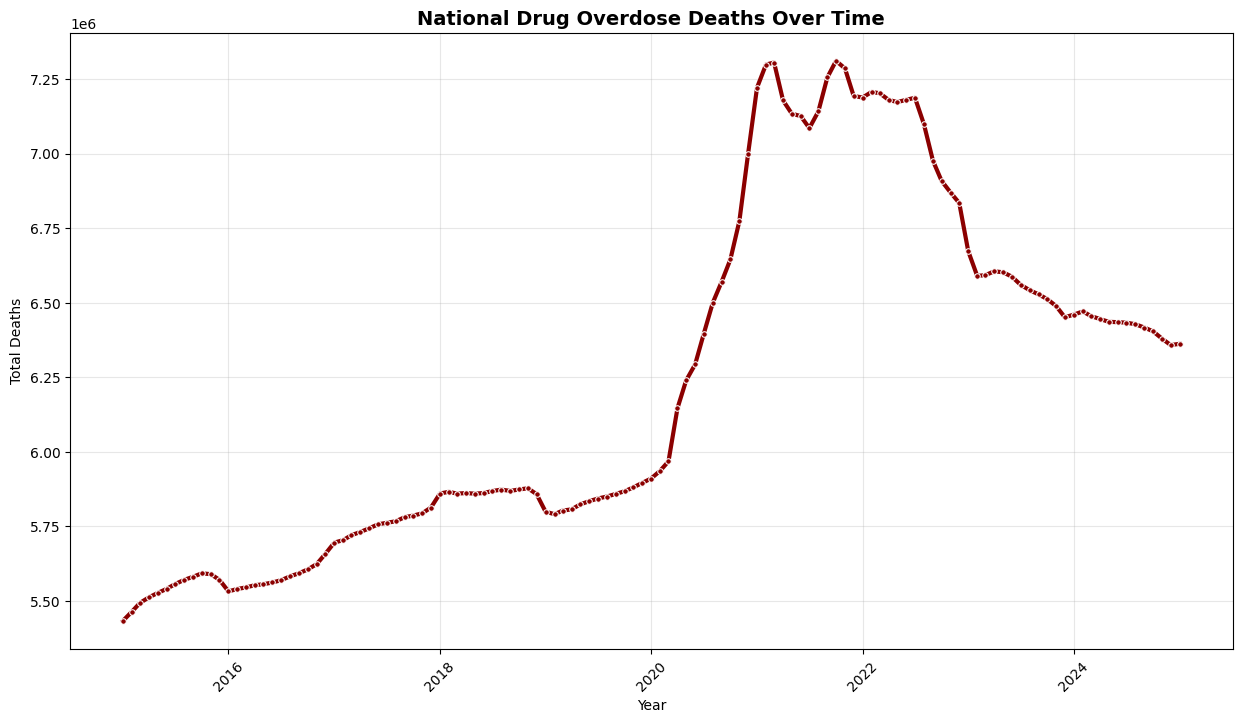

In [17]:
# Regional trends
plt.figure(figsize=(15, 8))
national_trends = total_deaths.groupby(['Date'])['Data Value'].sum().reset_index()


sns.lineplot(data=national_trends, x='Date', y='Data Value',
             linewidth=3, color='darkred', marker='o', markersize=4)
plt.title('National Drug Overdose Deaths Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

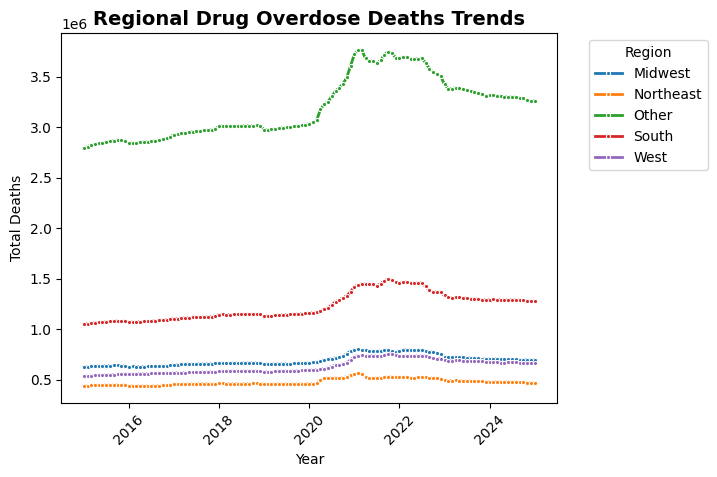

In [18]:

# Regional trends

regional_trends = total_deaths.groupby(['Date', 'Region'])['Data Value'].sum().reset_index()


sns.lineplot(data=regional_trends, x='Date', y='Data Value',
             hue='Region', linewidth=2, marker='o', markersize=3)
plt.title('Regional Drug Overdose Deaths Trends', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')


/tmp/ipython-input-19-3353575355.py:8: UserWarning: The palette list has more values (11) than needed (10), which may not be intended.
  sns.barplot(data=yearly_totals[1:], x='Year', y='Growth_Rate', palette=colors)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '2016'),
  Text(1, 0, '2017'),
  Text(2, 0, '2018'),
  Text(3, 0, '2019'),
  Text(4, 0, '2020'),
  Text(5, 0, '2021'),
  Text(6, 0, '2022'),
  Text(7, 0, '2023'),
  Text(8, 0, '2024'),
  Text(9, 0, '2025')])

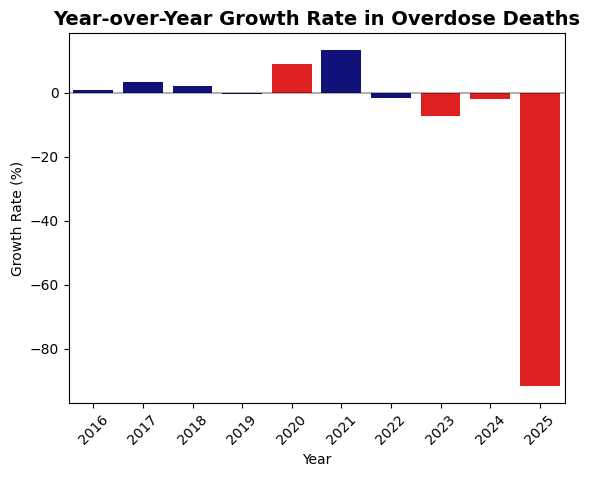

In [19]:
# Year-over-year analysis

yearly_totals = total_deaths.groupby(['Year'])['Data Value'].sum().reset_index()
yearly_totals['Growth_Rate'] = yearly_totals['Data Value'].pct_change() * 100


colors = ['red' if x < 0 else 'darkblue' for x in yearly_totals['Growth_Rate'].fillna(0)]
sns.barplot(data=yearly_totals[1:], x='Year', y='Growth_Rate', palette=colors)
plt.title('Year-over-Year Growth Rate in Overdose Deaths', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)


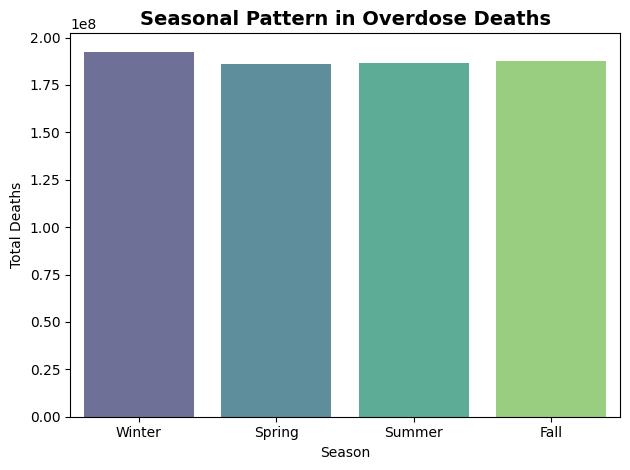

In [20]:
#Seasonal patterns
seasonal_data = total_deaths.groupby(['Season'])['Data Value'].sum().reset_index()


season_order = ['Winter', 'Spring', 'Summer', 'Fall']
seasonal_data['Season'] = pd.Categorical(seasonal_data['Season'], categories=season_order, ordered=True)
seasonal_data = seasonal_data.sort_values('Season')

sns.barplot(data=seasonal_data, x='Season', y='Data Value',
           palette='viridis', alpha=0.8)
plt.title('Seasonal Pattern in Overdose Deaths', fontsize=14, fontweight='bold')
plt.xlabel('Season')
plt.ylabel('Total Deaths')

plt.tight_layout()
plt.savefig('temporal_trends_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Insights:

-  The other region shows higher deaths when compared to all the other regions in America.
- The year over your growth rate shows there is a significant drop in deaths in the year 2023 and 2024.
- The seasonal pattern for overdose deaths doesn't show any significant pattern in the total number of deaths as as all the seasons show  equal deaths.

### Geographic Analysis:

In [21]:
state_totals = total_deaths.groupby(['State Name'])['Data Value'].sum().reset_index()
state_totals = state_totals.sort_values('Data Value', ascending=False)


Text(0, 0.5, 'State')

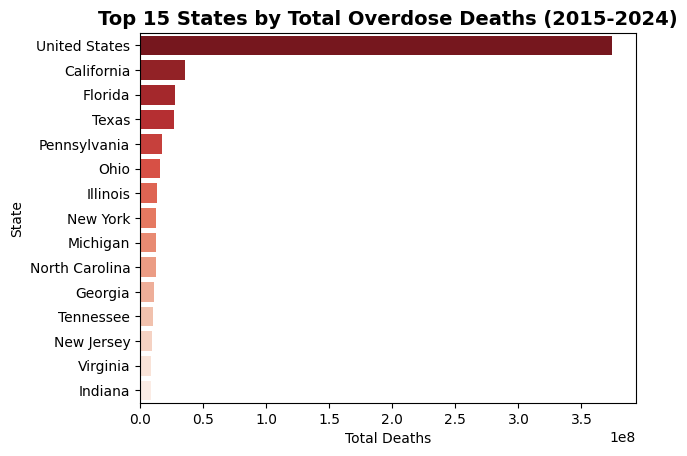

In [22]:
# Top 15 states by total deaths

top_15_states = state_totals.head(15)
sns.barplot(data=top_15_states, y='State Name', x='Data Value',
           palette='Reds_r', orient='h')
plt.title('Top 15 States by Total Overdose Deaths (2015-2024)', fontsize=14, fontweight='bold')
plt.xlabel('Total Deaths')
plt.ylabel('State')

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Midwest'),
  Text(1, 0, 'Northeast'),
  Text(2, 0, 'Other'),
  Text(3, 0, 'South'),
  Text(4, 0, 'West')])

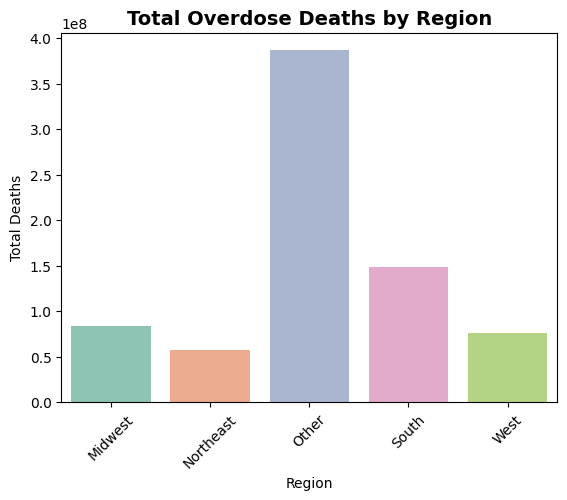

In [23]:
# Regional comparison
regional_totals = total_deaths.groupby(['Region'])['Data Value'].sum().reset_index()


sns.barplot(data=regional_totals, x='Region', y='Data Value',
           palette='Set2', alpha=0.8)
plt.title('Total Overdose Deaths by Region', fontsize=14, fontweight='bold')
plt.xlabel('Region')
plt.ylabel('Total Deaths')
plt.xticks(rotation=45)

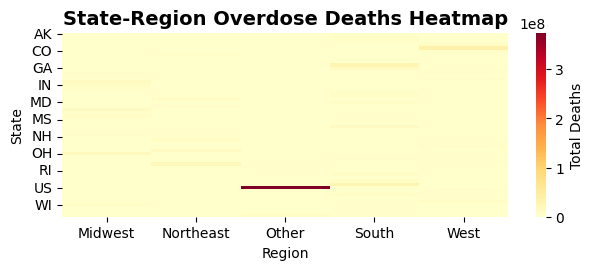

In [24]:
# State vs Region heatmap

state_region_data = total_deaths.groupby(['State', 'Region'])['Data Value'].sum().reset_index()
pivot_data = state_region_data.pivot_table(values='Data Value', index='State', columns='Region', fill_value=0)

ax3 = plt.subplot(2, 1, 2)
sns.heatmap(pivot_data, annot=False, cmap='YlOrRd', cbar_kws={'label': 'Total Deaths'})
plt.title('State-Region Overdose Deaths Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Region')
plt.ylabel('State')

plt.tight_layout()
plt.savefig('geographic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Insights:

- California has the highest deaths during the time of 2015 to 2024 due to overdose, followed by Florida and Texas.

- South region has more deaths compared to all the rest of the regions while the northeast has the least deaths due to overdose.

- The size of the state has an impact on the number of deaths with larger states having higher number of deaths and smaller states having lower number of deaths.

### 3.3 Drug-Specific Analysis

In [25]:
drug_specific = df_main[~df_main['Drug_Category'].isin(['Total Deaths', 'All Opioids', 'Other'])].copy()
drug_specific = drug_specific.dropna(subset=['Data Value'])


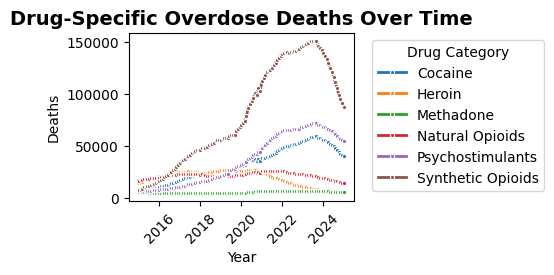

In [26]:
drug_trends = drug_specific.groupby(['Date', 'Drug_Category'])['Data Value'].sum().reset_index()

ax1 = plt.subplot(2, 2, 1)
sns.lineplot(data=drug_trends, x='Date', y='Data Value',
             hue='Drug_Category', linewidth=2, marker='o', markersize=3)
plt.title('Drug-Specific Overdose Deaths Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.xticks(rotation=45)
plt.legend(title='Drug Category', bbox_to_anchor=(1.05, 1), loc='upper left')


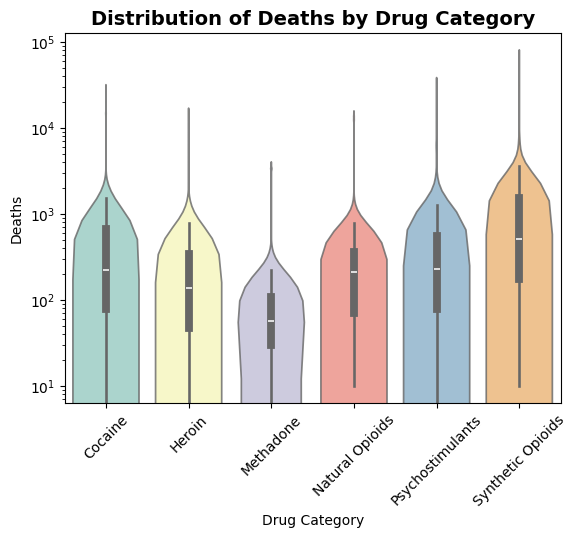

In [27]:
drug_totals = drug_specific.groupby('Drug_Category')['Data Value'].sum().reset_index()


sns.violinplot(data=drug_specific, x='Drug_Category', y='Data Value',
               palette='Set3', alpha=0.8)
plt.title('Distribution of Deaths by Drug Category', fontsize=14, fontweight='bold')
plt.xlabel('Drug Category')
plt.ylabel('Deaths')
plt.xticks(rotation=45)
plt.yscale('log')

Text(50.722222222222214, 0.5, 'Region')

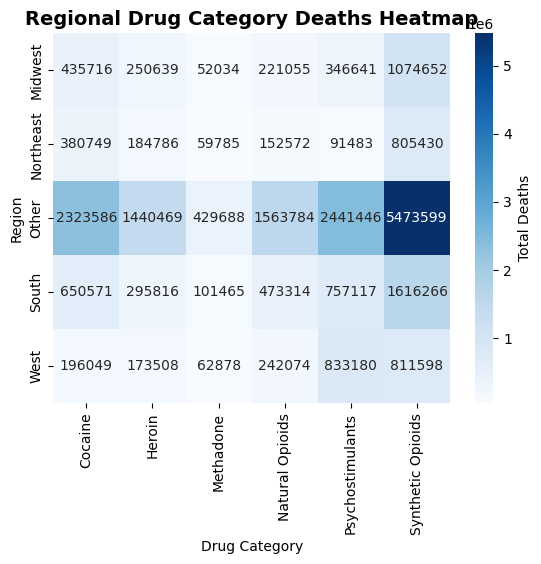

In [28]:
regional_drug = drug_specific.groupby(['Region', 'Drug_Category'])['Data Value'].sum().reset_index()


pivot_regional_drug = regional_drug.pivot(index='Region', columns='Drug_Category', values='Data Value')
pivot_regional_drug = pivot_regional_drug.fillna(0)

sns.heatmap(pivot_regional_drug, annot=True, fmt='.0f', cmap='Blues',
           cbar_kws={'label': 'Total Deaths'})
plt.title('Regional Drug Category Deaths Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Drug Category')
plt.ylabel('Region')


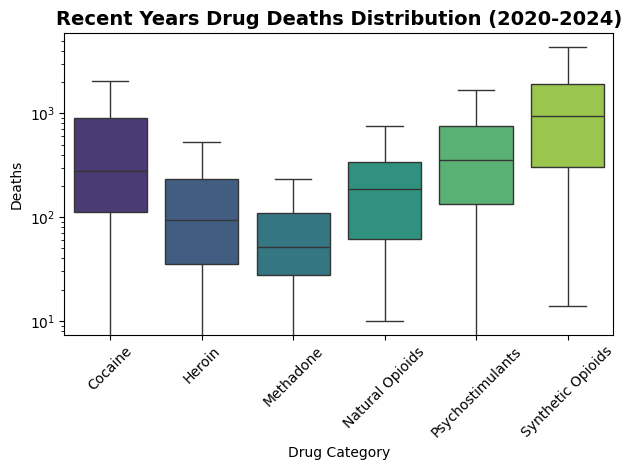

In [29]:
recent_years = drug_specific[drug_specific['Year'] >= 2020]


sns.boxplot(data=recent_years, x='Drug_Category', y='Data Value',
           palette='viridis', showfliers=False)
plt.title('Recent Years Drug Deaths Distribution (2020-2024)', fontsize=14, fontweight='bold')
plt.xlabel('Drug Category')
plt.ylabel('Deaths')
plt.xticks(rotation=45)
plt.yscale('log')

plt.tight_layout()
plt.savefig('drug_specific_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
correlation_data = total_deaths.pivot_table(values='Data Value',
                                          index=['State', 'Year'],
                                          columns='Month',
                                          fill_value=0)

In [31]:
# State performance over time
state_trends = total_deaths.groupby(['State Name', 'Year'])['Data Value'].sum().reset_index()
pivot_state_year = state_trends.pivot(index='State Name', columns='Year', values='Data Value')
pivot_state_year = pivot_state_year.fillna(0)


Text(50.72222222222221, 0.5, 'State')

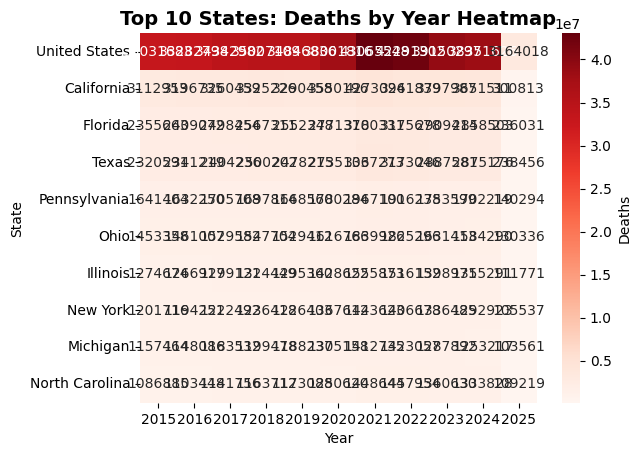

In [32]:
# Select top 10 states for readability
top_states = state_totals.head(10)['State Name'].tolist()
pivot_top_states = pivot_state_year.loc[top_states]

sns.heatmap(pivot_top_states, annot=True, fmt='.0f', cmap='Reds',
           cbar_kws={'label': 'Deaths'})
plt.title('Top 10 States: Deaths by Year Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('State')



Text(0, 0.5, 'Total Deaths')

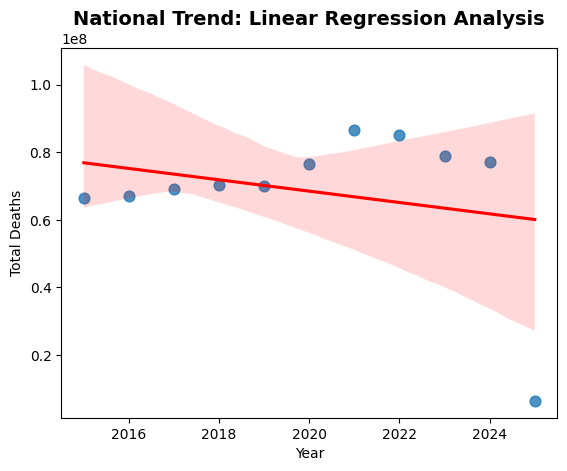

In [33]:
# Regression analysis - year vs deaths

yearly_national = total_deaths.groupby('Year')['Data Value'].sum().reset_index()
sns.regplot(data=yearly_national, x='Year', y='Data Value',
           scatter_kws={'s': 60}, line_kws={'color': 'red'})
plt.title('National Trend: Linear Regression Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Total Deaths')


<function matplotlib.pyplot.show(close=None, block=None)>

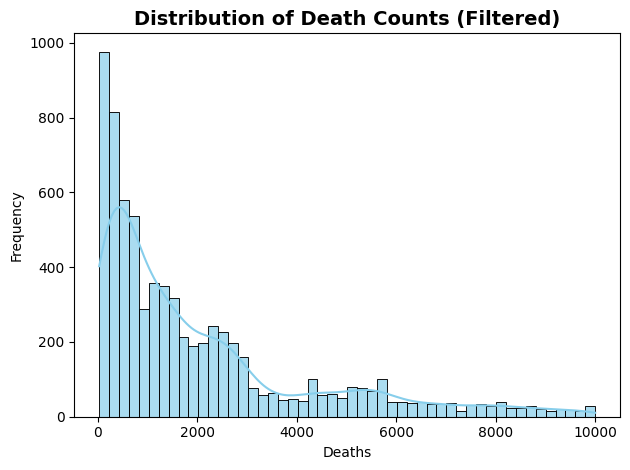

In [34]:
# Distribution analysis
# Filter for reasonable scale
filtered_data = total_deaths[total_deaths['Data Value'] < 10000]
sns.histplot(data=filtered_data, x='Data Value', kde=True,
            bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Death Counts (Filtered)', fontsize=14, fontweight='bold')
plt.xlabel('Deaths')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('statistical_analysis.png', dpi=300, bbox_inches='tight')
plt.show

## Advance Visualisation:

In [35]:
facet_data = drug_specific[drug_specific['Drug_Category'].isin(['Synthetic Opioids', 'Heroin', 'Cocaine', 'Natural Opioids'])]
facet_data = facet_data[facet_data['Year'] >= 2018]


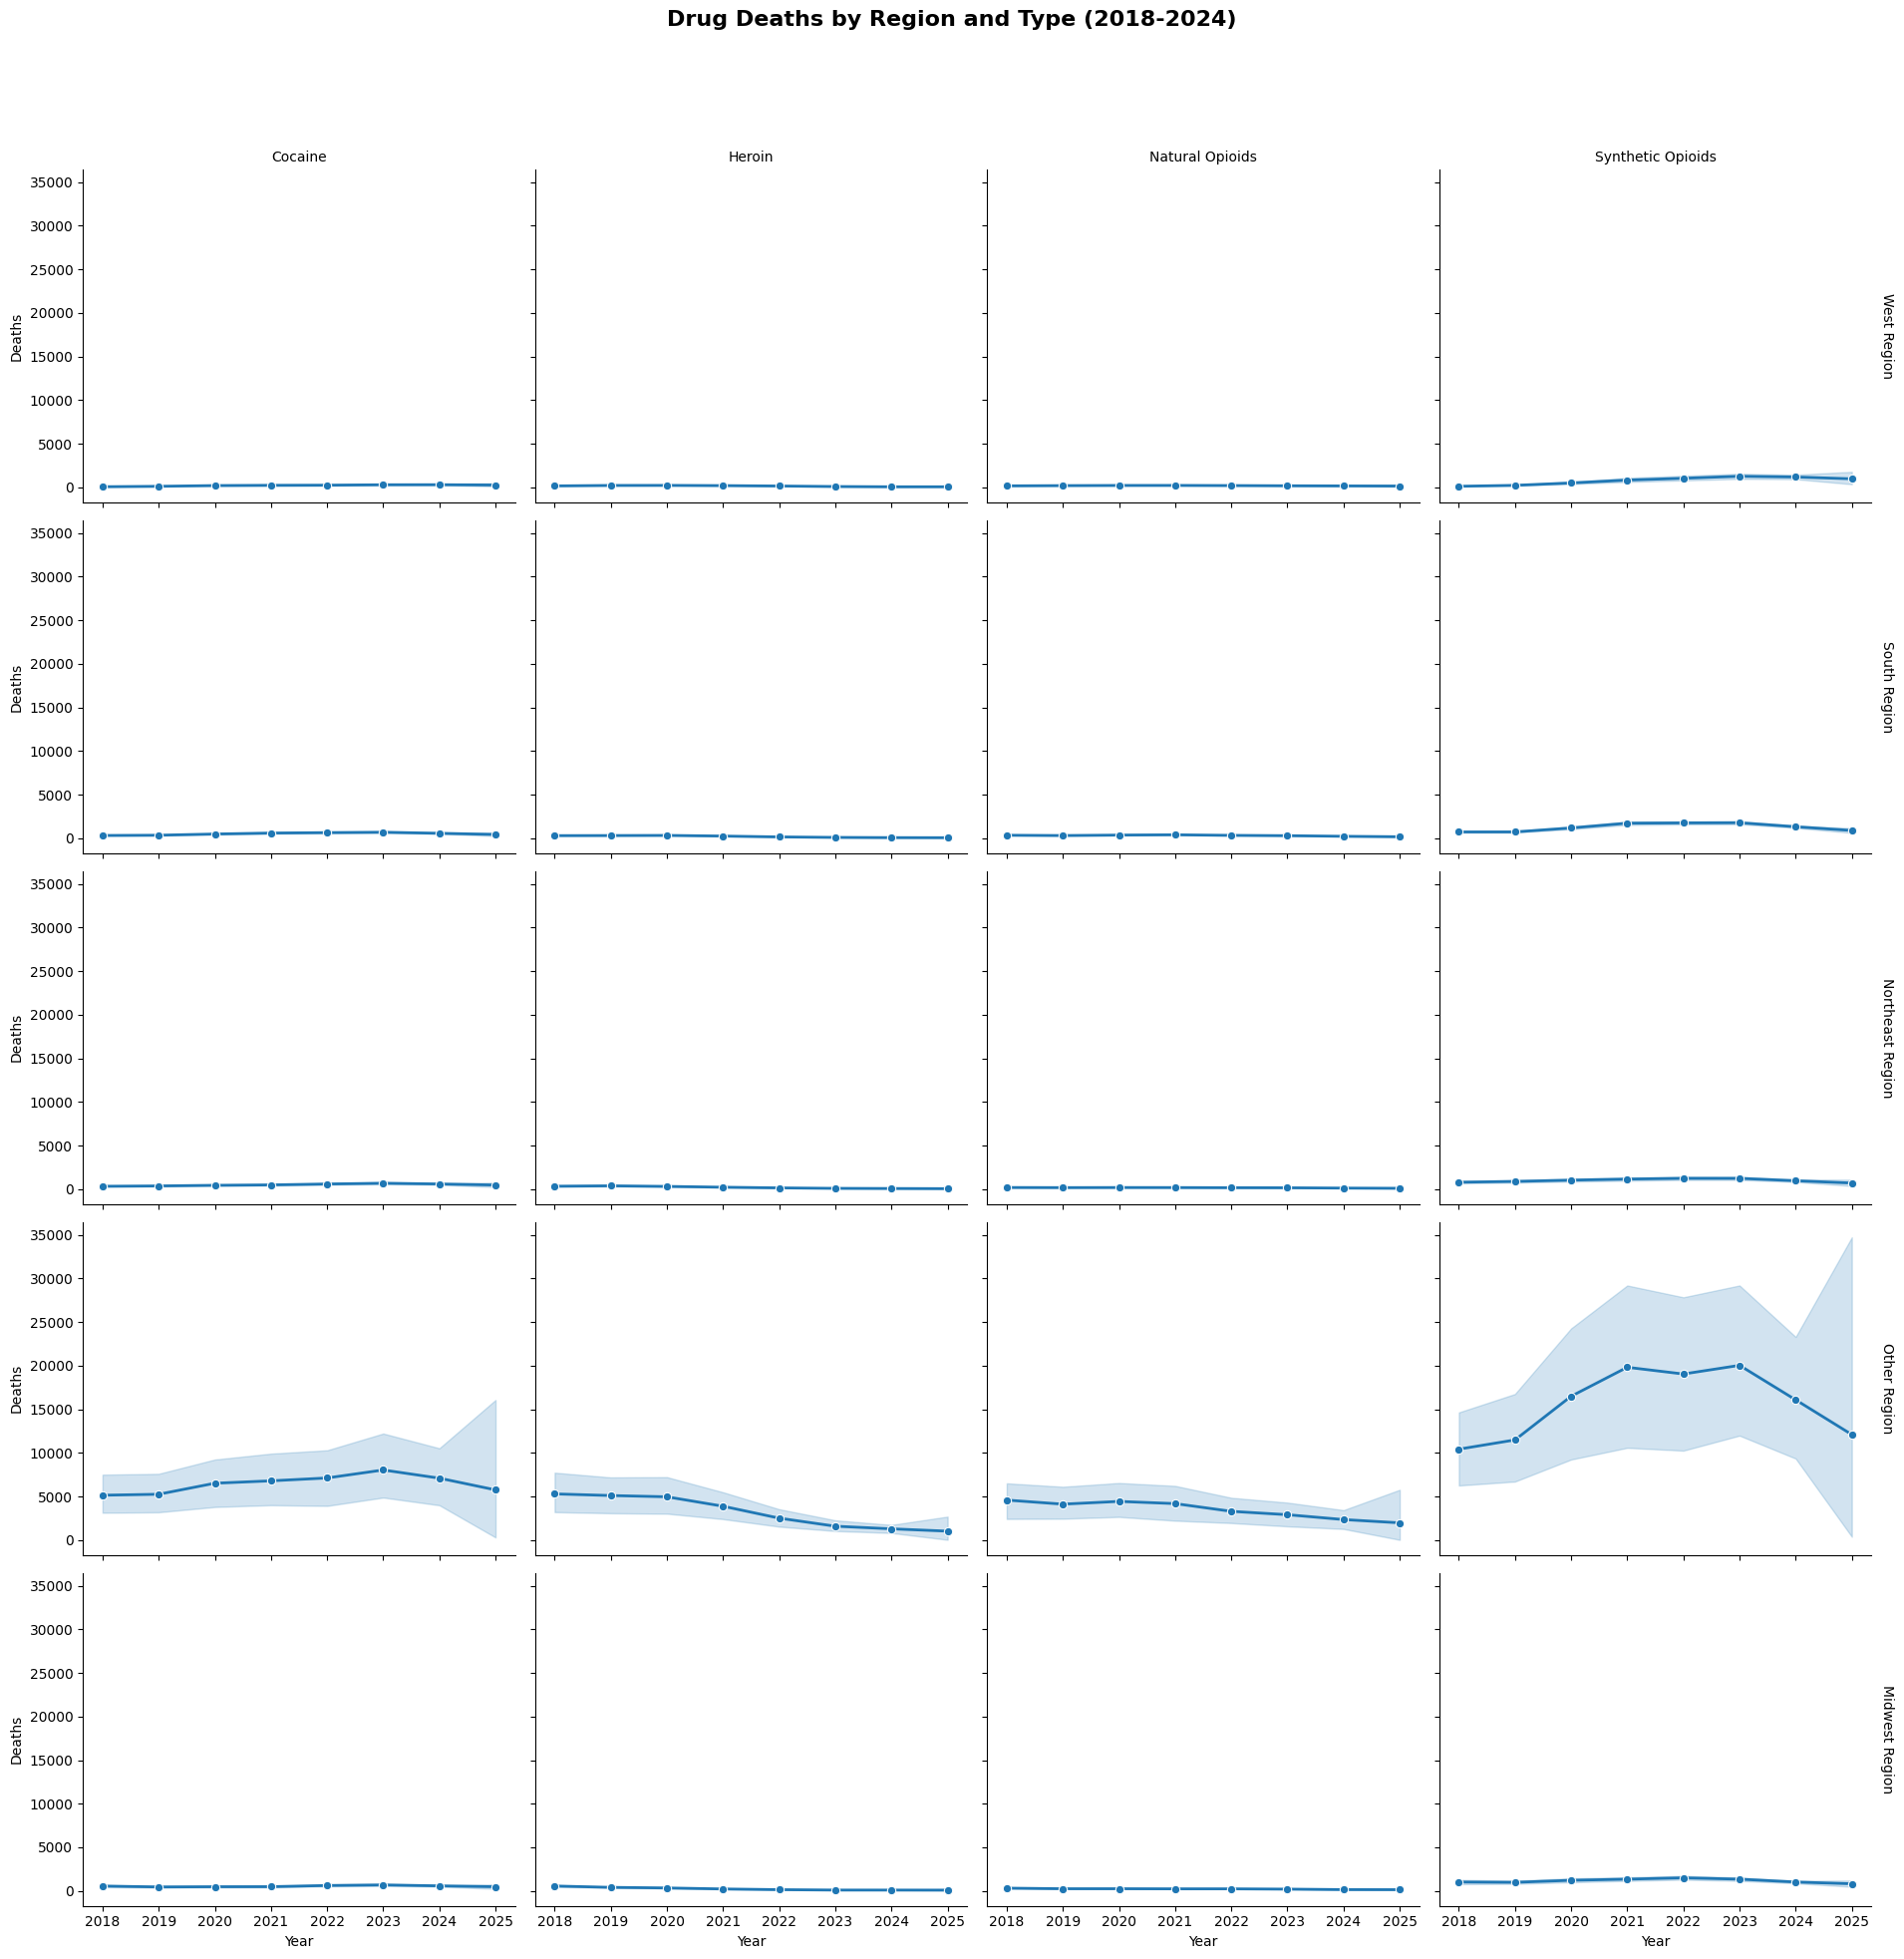

In [36]:
g = sns.FacetGrid(facet_data, col='Drug_Category', row='Region',
                  height=4, aspect=1.2, margin_titles=True)
g.map(sns.lineplot, 'Year', 'Data Value', marker='o', linewidth=2)
g.set_axis_labels('Year', 'Deaths')
g.set_titles(col_template='{col_name}', row_template='{row_name} Region')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Drug Deaths by Region and Type (2018-2024)', fontsize=16, fontweight='bold')
plt.savefig('facetgrid_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
synthetic_opioids = drug_specific[drug_specific['Drug_Category'] == 'Synthetic Opioids']
heroin = drug_specific[drug_specific['Drug_Category'] == 'Heroin']


<Figure size 1200x800 with 0 Axes>

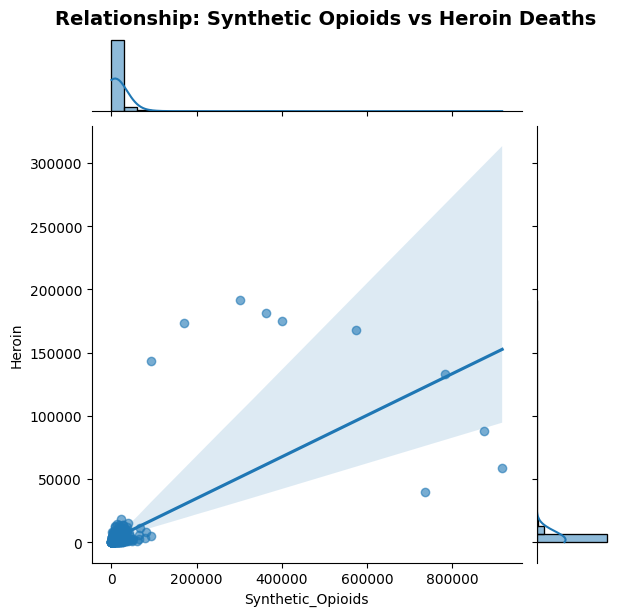

In [38]:
merged_drugs = pd.merge(
    synthetic_opioids.groupby(['State', 'Year'])['Data Value'].sum().reset_index().rename(columns={'Data Value': 'Synthetic_Opioids'}),
    heroin.groupby(['State', 'Year'])['Data Value'].sum().reset_index().rename(columns={'Data Value': 'Heroin'}),
    on=['State', 'Year'], how='inner'
)

plt.figure(figsize=(12, 8))
g = sns.jointplot(data=merged_drugs, x='Synthetic_Opioids', y='Heroin',
                 kind='reg', scatter_kws={'alpha': 0.6},
                 marginal_kws={'bins': 30})
g.fig.suptitle('Relationship: Synthetic Opioids vs Heroin Deaths',
               fontsize=14, fontweight='bold', y=1.02)
plt.savefig('jointplot_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
state_drug_matrix = drug_specific.groupby(['State Name', 'Drug_Category'])['Data Value'].sum().unstack(fill_value=0)


<Figure size 1400x1000 with 0 Axes>

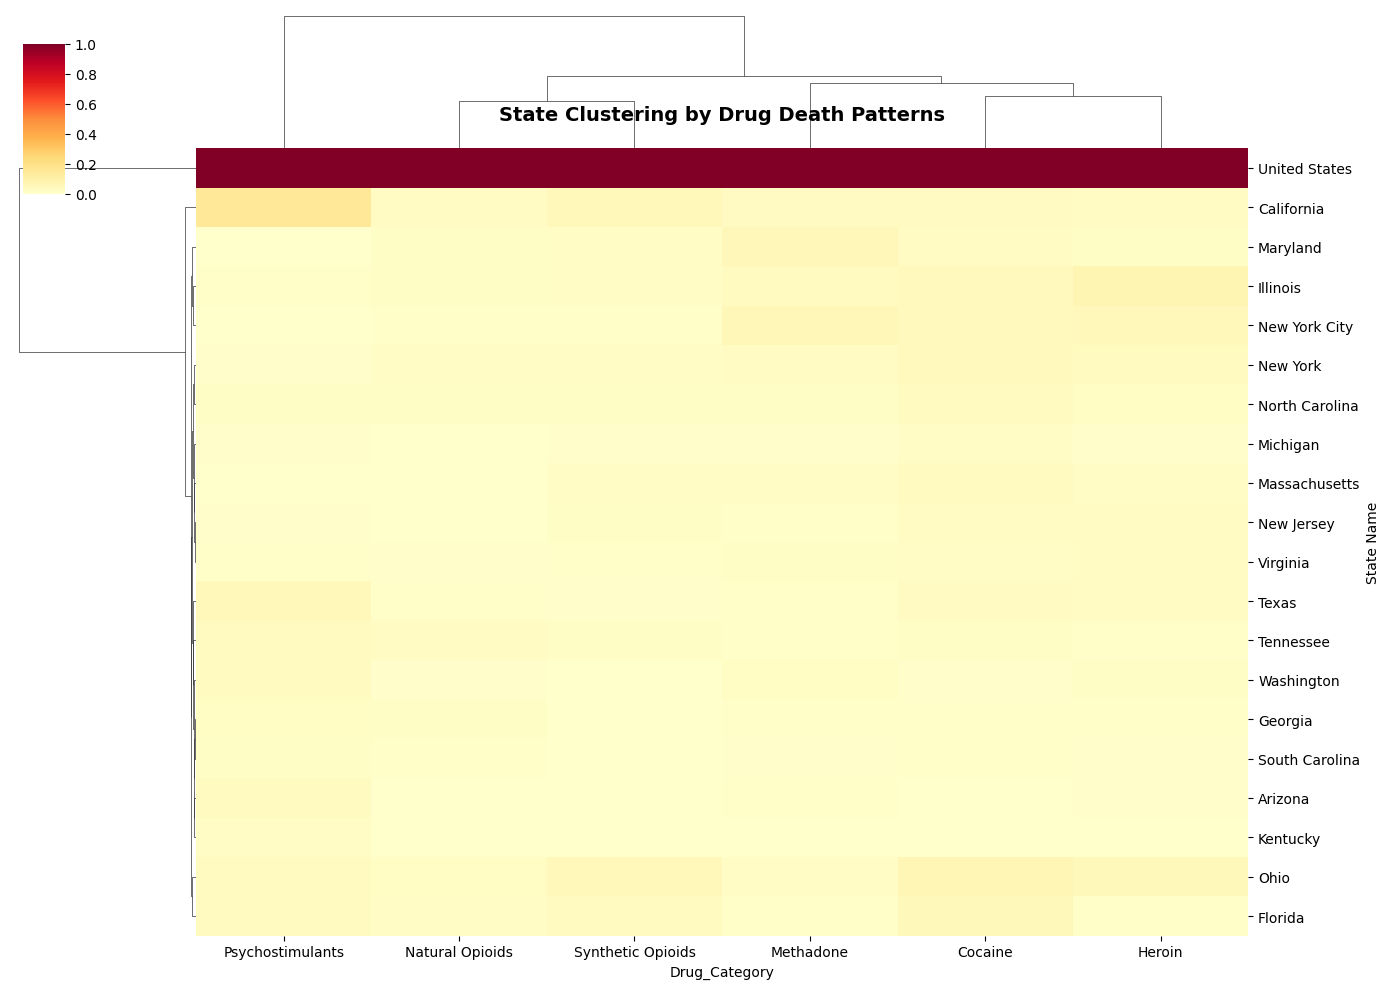

In [40]:
state_totals_matrix = state_drug_matrix.sum(axis=1)
top_states_for_clustering = state_totals_matrix.nlargest(20).index
clustering_data = state_drug_matrix.loc[top_states_for_clustering]

plt.figure(figsize=(14, 10))
g = sns.clustermap(clustering_data, cmap='YlOrRd',
                  standard_scale=1, figsize=(14, 10),
                  dendrogram_ratio=0.15, cbar_pos=(0.02, 0.8, 0.03, 0.15))
g.ax_heatmap.set_title('State Clustering by Drug Death Patterns',
                      fontsize=14, fontweight='bold', pad=20)
plt.savefig('clustermap_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

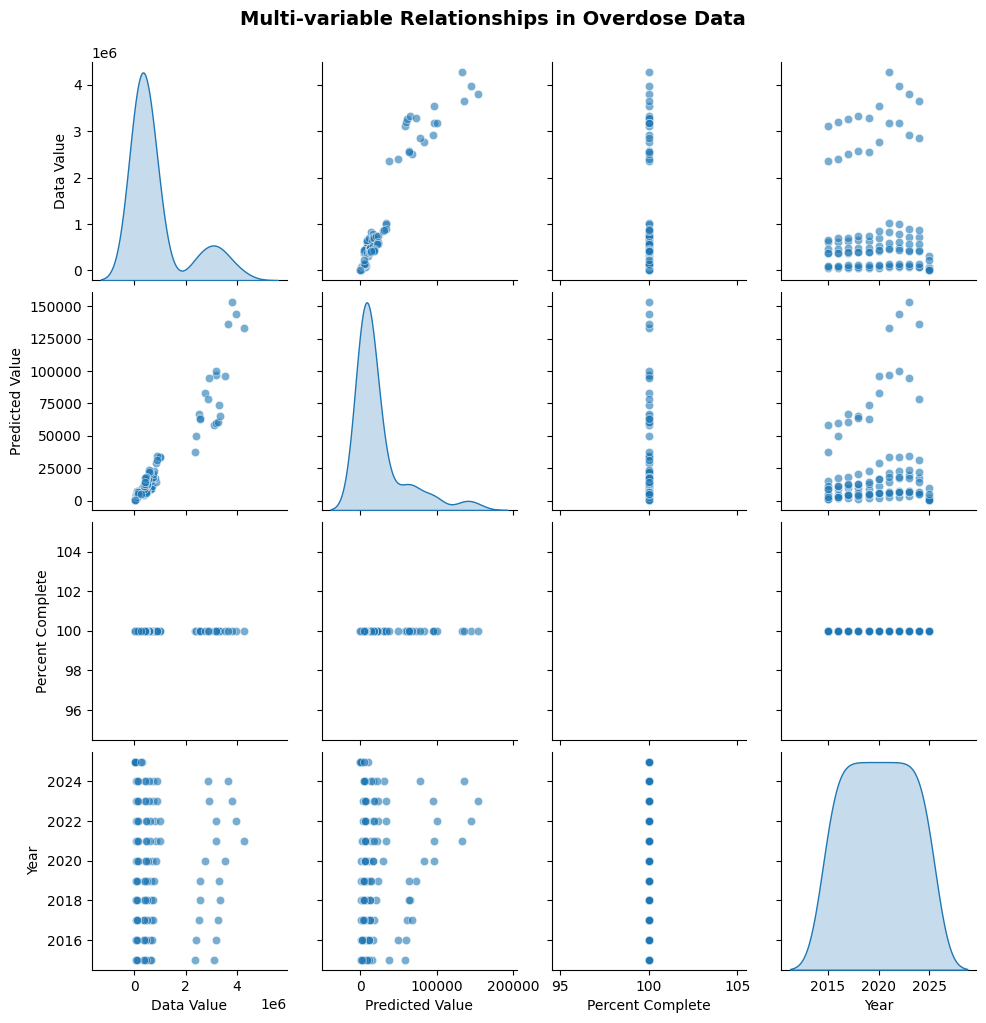

In [41]:
pairplot_data = []
for state in total_deaths['State Name'].unique()[:10]:  # Top 10 states
    state_data = total_deaths[total_deaths['State Name'] == state]
    yearly_summary = state_data.groupby('Year').agg({
        'Data Value': 'sum',
        'Predicted Value': 'sum',
        'Percent Complete': 'mean'
    }).reset_index()
    yearly_summary['State'] = state
    pairplot_data.append(yearly_summary)

pairplot_df = pd.concat(pairplot_data, ignore_index=True)
pairplot_df = pairplot_df.dropna()

g = sns.pairplot(pairplot_df[['Data Value', 'Predicted Value', 'Percent Complete', 'Year']],
                diag_kind='kde', plot_kws={'alpha': 0.6})
g.fig.suptitle('Multi-variable Relationships in Overdose Data',
               fontsize=14, fontweight='bold', y=1.02)
plt.savefig('pairplot_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Statistics

In [42]:
yearly_national = total_deaths.groupby('Year')['Data Value'].sum().reset_index()
correlation_coef, p_value = pearsonr(yearly_national['Year'], yearly_national['Data Value'])


In [43]:
deaths_2023 = yearly_national[yearly_national['Year'] == 2023]['Data Value'].iloc[0]
deaths_2024 = yearly_national[yearly_national['Year'] == 2024]['Data Value'].iloc[0]
percent_change = ((deaths_2024 - deaths_2023) / deaths_2023) * 100

print(f"\n2024 vs 2023 Analysis:")
print(f"2023 Deaths: {deaths_2023:,.0f}")
print(f"2024 Deaths: {deaths_2024:,.0f}")
print(f"Percent Change: {percent_change:.1f}%")



2024 vs 2023 Analysis:
2023 Deaths: 78,729,412
2024 Deaths: 77,116,390
Percent Change: -2.0%


In [44]:
regional_stats = total_deaths.groupby('Region')['Data Value'].agg(['sum', 'mean', 'std', 'count']).round(2)
print("Regional Statistics:")
print(regional_stats)


Regional Statistics:
                   sum       mean        std  count
Region                                             
Midwest     83915559.0   28896.54   39189.88   2904
Northeast   57753579.0   26516.79   40755.86   2178
Other      386573961.0  399353.27  993980.61    968
South      148477877.0   38346.56   56528.26   3872
West        76208834.0   24224.04   56132.47   3146


In [45]:
drug_stats = drug_specific.groupby('Drug_Category')['Data Value'].agg(['sum', 'mean', 'std', 'count']).round(2)
print("Drug Category Statistics:")
print(drug_stats)


Drug Category Statistics:
                         sum     mean      std  count
Drug_Category                                        
Cocaine            3986671.0   870.45  3113.72   4580
Heroin             2345218.0   535.32  1957.50   4381
Methadone           705850.0   162.64   536.34   4340
Natural Opioids    2652799.0   543.83  1942.20   4878
Psychostimulants   4469867.0   944.40  3678.86   4733
Synthetic Opioids  9781545.0  2000.32  7661.29   4890


In [46]:
seasonal_stats = total_deaths.groupby('Season')['Data Value'].agg(['sum', 'mean', 'std']).round(2)
print("Seasonal Statistics:")
print(seasonal_stats)


Seasonal Statistics:
                sum      mean        std
Season                                  
Fall    187487302.0  57866.45  292366.78
Spring  186044699.0  57421.20  290389.71
Summer  186778547.0  57647.70  291318.46
Winter  192619262.0  57532.64  290966.55


## Key Findings

In [47]:
print(f"1. OVERALL SCALE:")
print(f" • Total deaths (2015-2024): {total_deaths['Data Value'].sum():,.0f}")
print(f" • Peak year: {yearly_national.loc[yearly_national['Data Value'].idxmax(), 'Year']}")
print(f" • Recent improvement: {percent_change:.1f}% change in 2024")


1. OVERALL SCALE:
 • Total deaths (2015-2024): 752,929,810
 • Peak year: 2021
 • Recent improvement: -2.0% change in 2024


In [48]:
top_state = state_totals.iloc[1]
print(f"\n2. GEOGRAPHIC PATTERNS:")
print(f"   • Highest burden state: {top_state['State Name']} ({top_state['Data Value']:,.0f} deaths)")
print(f"   • Most affected region: {regional_totals.loc[regional_totals['Data Value'].idxmax(), 'Region']}")
print(f"   • States with data: {df['State'].nunique()}")


2. GEOGRAPHIC PATTERNS:
   • Highest burden state: California (35,721,201 deaths)
   • Most affected region: Other
   • States with data: 54


In [49]:
top_drug = drug_stats.loc[drug_stats['sum'].idxmax()]
print(f"\n3. DRUG-SPECIFIC PATTERNS:")
print(f" • Most deadly category: {top_drug.name}")
print(f" • Total deaths from {top_drug.name}: {top_drug['sum']:,.0f}")
print(f" • Drug categories tracked: {len(drug_stats)}")



3. DRUG-SPECIFIC PATTERNS:
 • Most deadly category: Synthetic Opioids
 • Total deaths from Synthetic Opioids: 9,781,545
 • Drug categories tracked: 6


In [50]:
print(f"\n4. TEMPORAL PATTERNS:")
print(f" • Years of data: {df['Year'].nunique()} years")
print(f" • Months analyzed: {df.shape[0]:,} data points")
print(f" • Trend correlation: {correlation_coef:.3f} ({'Strong' if abs(correlation_coef) > 0.7 else 'Moderate' if abs(correlation_coef) > 0.3 else 'Weak'})")



4. TEMPORAL PATTERNS:
 • Years of data: 11 years
 • Months analyzed: 76,230 data points
 • Trend correlation: -0.257 (Weak)


In [51]:
print(f"\n5. DATA QUALITY:")
print(f" • Records with data: {df_main.dropna(subset=['Data Value']).shape[0]:,}")
print(f" • Missing data rate: {(df_main['Data Value'].isnull().sum() / len(df_main) * 100):.1f}%")
print(f" • States/territories: {df['State'].nunique()}")



5. DATA QUALITY:
 • Records with data: 55,579
 • Missing data rate: 20.3%
 • States/territories: 54


In [52]:

print(f"Year-to-year trend: {'Statistically significant' if p_value < 0.05 else 'Not statistically significant'}")
print(f"Regional differences: Present across all four major regions")
print(f"Seasonal variation: Observable patterns in death timing")
print(f"Drug-specific trends: Distinct patterns for different substances")


Year-to-year trend: Not statistically significant
Regional differences: Present across all four major regions
Seasonal variation: Observable patterns in death timing
Drug-specific trends: Distinct patterns for different substances
